In [1]:
import math
import random
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from scipy.stats import gamma
from scipy.optimize import curve_fit
import itertools
from itertools import combinations
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import cm
import matplotlib 
%matplotlib inline

In [2]:
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf');

font = matplotlib.font_manager.FontProperties(fname='/System/Library/Fonts/Supplemental/Avenir.ttf')

In [3]:
plt.rcParams.update({'text.usetex': False,
                     'font.family': "sans-serif",
                     'text.latex.preamble': r"\usepackage{amsmath}"})

In [4]:
# sandpiper's heterozygosity (see Methods)
H = 0.00057

# selection coefficient values for which we ran simulations (see ../simulations)
s = ([0] + list(-1 * np.logspace(-5, 0, 90)))[::-1][1:]

# fraction of new mutations that are lethal and recessive
fracs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

# the rest of new mutations are assumed to be codominant,
# with selection coefficients drawn from a gamma distribution:
n = 21
alphas = np.logspace(0, np.log10(300), n)
scales = np.logspace(-7, -3, n) 


In [5]:
# input and output paths
out_path = '../data/fitted_s_parameters.txt' # where to save the fitted distribution parameters

# simulated values of H for a range of s (see above) and h = 0 
# w/ code in ../simulations
h_s_recessive_path = '../data/H_s_recessive.txt' # w/ complex demographic history
h_s_recessive_bottleneck_path = '../data/H_s_recessive_bottleneck.txt' # w/ bottleneck only

# simulated values of H for a range of s (see above) and h = 1/2
# w/ code in ../simulations
h_s_codominant_path = '../data/H_s_codominant.txt' # w/ complex demographic history
h_s_codominant_bottleneck_path = '../data/H_s_codominant_bottleneck.txt' # w/ bottleneck only

# simulated genotype fitness values, for parameter combinations in ../data/fitted_s_parameters.txt 
fitness_diff_path = '../data/fitness_diff.txt' # w/ the complex demographic history
fitness_diff_bottleneck_path = '../data/fitness_diff_bottleneck.txt' # w/ the complex demographic history


In [6]:
# reading simulation results for h = 0:

avg_H_recessive_s_const_N_dict = {} # before population growth
avg_H_recessive_s_decline_only_dict = {} # after population decline
avg_H_recessive_s_dict = {} # after population growth and decline

avg_n_pol_recessive_s_const_N_dict = {} # before population growth
avg_n_pol_recessive_s_decline_only_dict = {} # after population decline
avg_n_pol_recessive_s_dict = {} # after population growth and decline 

with open(h_s_recessive_path) as o:
    H_s_recessive_lines = o.readlines()
    
for i in range(1, len(H_s_recessive_lines)):
    avg_H_const_N = float(H_s_recessive_lines[i].strip('\n').split('\t')[2])
    avg_H = float(H_s_recessive_lines[i].strip('\n').split('\t')[8])

    avg_n_pol_const_N = float(H_s_recessive_lines[i].strip('\n').split('\t')[1])
    avg_n_pol = float(H_s_recessive_lines[i].strip('\n').split('\t')[7])
    
    sel = float(H_s_recessive_lines[i].split('\t')[0]) / 10 # rescaling the selection coefficient back
    
    # making sure that there were no rounding errors:
    if sel in s:
        avg_H_recessive_s_const_N_dict[sel] = avg_H_const_N
        avg_H_recessive_s_dict[sel] = avg_H
        
        avg_n_pol_recessive_s_const_N_dict[sel] = avg_n_pol_const_N
        avg_n_pol_recessive_s_dict[sel] = avg_n_pol
        
    else: 
        correct_sel = s[min(range(len(s)), key = lambda x: abs(s[x] - sel))]
        avg_H_recessive_s_const_N_dict[correct_sel] = avg_H_const_N
        avg_H_recessive_s_dict[correct_sel] = avg_H
        
        avg_n_pol_recessive_s_const_N_dict[correct_sel] = avg_n_pol_const_N
        avg_n_pol_recessive_s_dict[correct_sel] = avg_n_pol
        
with open(h_s_recessive_bottleneck_path) as o:
    H_s_recessive_lines = o.readlines()

for i in range(1, len(H_s_recessive_lines)):
    avg_H = float(H_s_recessive_lines[i].strip('\n').split('\t')[8])
    avg_n_pol = float(H_s_recessive_lines[i].strip('\n').split('\t')[7])
    
    sel = float(H_s_recessive_lines[i].split('\t')[0]) / 10 # rescaling the selection coefficient back
    
    # making sure that there were no rounding errors:
    if sel in s:
        avg_H_recessive_s_decline_only_dict[sel] = avg_H
        avg_n_pol_recessive_s_decline_only_dict[sel] = avg_n_pol
        
    else: 
        correct_sel = s[min(range(len(s)), key = lambda x: abs(s[x] - sel))]
        avg_H_recessive_s_decline_only_dict[correct_sel] = avg_H
        avg_n_pol_recessive_s_decline_only_dict[correct_sel] = avg_n_pol

In [7]:
# reading simulation results for h = 0.5:

avg_H_codominant_s_const_N_dict = {} # before population growth
avg_H_codominant_s_decline_only_dict = {} # after population decline
avg_H_codominant_s_dict = {} # after population growth and decline

avg_n_pol_codominant_s_const_N_dict = {} # before population growth
avg_n_pol_codominant_s_decline_only_dict = {} # after population decline
avg_n_pol_codominant_s_dict = {} # after population growth and decline 

with open(h_s_codominant_path) as o:
    H_s_codominant_lines = o.readlines()
    
for i in range(1, len(H_s_codominant_lines)):
    avg_H_const_N = float(H_s_codominant_lines[i].strip('\n').split('\t')[2])
    avg_H = float(H_s_codominant_lines[i].strip('\n').split('\t')[8])

    avg_n_pol_const_N = float(H_s_codominant_lines[i].strip('\n').split('\t')[1])
    avg_n_pol = float(H_s_codominant_lines[i].strip('\n').split('\t')[7])
    
    sel = float(H_s_codominant_lines[i].split('\t')[0]) / 10 # rescaling the selection coefficient back
    
    # making sure that there were no rounding errors:
    if sel in s:
        avg_H_codominant_s_const_N_dict[sel] = avg_H_const_N
        avg_H_codominant_s_dict[sel] = avg_H
        
        avg_n_pol_codominant_s_const_N_dict[sel] = avg_n_pol_const_N
        avg_n_pol_codominant_s_dict[sel] = avg_n_pol
        
    else: 
        correct_sel = s[min(range(len(s)), key = lambda x: abs(s[x] - sel))]
        avg_H_codominant_s_const_N_dict[correct_sel] = avg_H_const_N
        avg_H_codominant_s_dict[correct_sel] = avg_H
        
        avg_n_pol_codominant_s_const_N_dict[correct_sel] = avg_n_pol_const_N
        avg_n_pol_codominant_s_dict[correct_sel] = avg_n_pol
        
with open(h_s_codominant_bottleneck_path) as o:
    H_s_codominant_lines = o.readlines()

for i in range(1, len(H_s_codominant_lines)):
    avg_H = float(H_s_codominant_lines[i].strip('\n').split('\t')[8])
    avg_n_pol = float(H_s_codominant_lines[i].strip('\n').split('\t')[7])
    
    sel = float(H_s_codominant_lines[i].split('\t')[0]) / 10 # rescaling the selection coefficient back
    
    # making sure that there were no rounding errors:
    if sel in s:
        avg_H_codominant_s_decline_only_dict[sel] = avg_H
        avg_n_pol_codominant_s_decline_only_dict[sel] = avg_n_pol
        
    else: 
        correct_sel = s[min(range(len(s)), key = lambda x: abs(s[x] - sel))]
        avg_H_codominant_s_decline_only_dict[correct_sel] = avg_H
        avg_n_pol_codominant_s_decline_only_dict[correct_sel] = avg_n_pol
        

In [8]:
# reading simulation results w/ fitness values for individual genotypes (see ../simulations):
# each line contains the proportion of lethal mutations, alpha, 1/beta, 
# and the absolute difference in the avg. fitness of an individual genotype before and after pop. size changes

with open(fitness_diff_path) as f:
    lines = [x.split() for x in f.readlines()]

avg_fitness_diff = {}
for line in lines:
    if float(line[0]) not in avg_fitness_diff:
        avg_fitness_diff[float(line[0])] = {}
        
    avg_fitness_diff[float(line[0])][(float(line[1]), float(line[2]))] = [float(x) for x in line[3:]]
    
    
with open(fitness_diff_bottleneck_path) as f:
    lines = [x.split() for x in f.readlines()]

avg_fitness_diff_decline_only = {}
for line in lines:
    if float(line[0]) not in avg_fitness_diff_decline_only:
        avg_fitness_diff_decline_only[float(line[0])] = {}
        
    avg_fitness_diff_decline_only[float(line[0])][(float(line[1]), float(line[2]))] = [float(x) for x in line[3:]]
    

In [9]:
# smoothing / interpolating data:

avg_H_recessive_s_const_N_lowess = sm.nonparametric.lowess(endog=[avg_H_recessive_s_const_N_dict[x] for x in s], exog=s, frac=0.05)
avg_H_recessive_s_lowess = sm.nonparametric.lowess(endog=[avg_H_recessive_s_dict[x] for x in s], exog=s, frac=0.05)
avg_H_recessive_s_decline_only_lowess = sm.nonparametric.lowess(endog=[avg_H_recessive_s_decline_only_dict[x] for x in s], exog=s, frac=0.05)

avg_n_pol_recessive_s_const_N_lowess = sm.nonparametric.lowess(endog=[avg_n_pol_recessive_s_const_N_dict[x] for x in s], exog=s, frac=0.07)
avg_n_pol_recessive_s_lowess = sm.nonparametric.lowess(endog=[avg_n_pol_recessive_s_dict[x] for x in s], exog=s, frac=0.07)
avg_n_pol_recessive_s_decline_only_lowess = sm.nonparametric.lowess(endog=[avg_n_pol_recessive_s_decline_only_dict[x] for x in s], exog=s, frac=0.07)

avg_H_codominant_s_const_N_lowess = sm.nonparametric.lowess(endog=[avg_H_codominant_s_const_N_dict[x] for x in s], exog=s, frac=0.06)
avg_H_codominant_s_lowess = sm.nonparametric.lowess(endog=[avg_H_codominant_s_dict[x] for x in s], exog=s, frac=0.06)
avg_H_codominant_s_decline_only_lowess = sm.nonparametric.lowess(endog=[avg_H_codominant_s_decline_only_dict[x] for x in s], exog=s, frac=0.06)

avg_n_pol_codominant_s_const_N_lowess = sm.nonparametric.lowess(endog=[avg_n_pol_codominant_s_const_N_dict[x] for x in s], exog=s, frac=0.05)
avg_n_pol_codominant_s_lowess = sm.nonparametric.lowess(endog=[avg_n_pol_codominant_s_dict[x] for x in s], exog=s, frac=0.05)
avg_n_pol_codominant_s_decline_only_lowess = sm.nonparametric.lowess(endog=[avg_n_pol_codominant_s_decline_only_dict[x] for x in s], exog=s, frac=0.05)

In [10]:
# note the deviation from linear scalings at s = -0.1 – this comes from rescaling s by 10 in simulations;
# otherwise we see that H \propto s^{-1/2} for h = 0 and H \propto s^{-1} for h = 0.5 in the negative tail, as exected for constant N;
# it is a bit difficult to see the almost two-fold difference on log scale between the H(s) lines for constant and changing N; it is better to look at the ratio of diversity measures on lineare scale

In [11]:
# calculating H for a mixture of gamma distribution of codominant s + a delta function for lethals (at s = -1e-2):

def get_H(alpha, scale, s, H_s, H_s_recessive_lethal, frac_lethal):
    # s are the s values where H values were computed
    # the beta parameter is 1/scale
    
    # increasing the length will increase presicion
    xs = ([0] + list(-1 * np.logspace(-10, 0, int(1e5))))[::-1] # will need to take abs(x) for the gamma function
    
    # interpolating H(s)
    H_s_interp = np.interp(xs, s, H_s)
    
    # getting pdf values
    norm = gamma.cdf(1, alpha, scale=scale) - gamma.cdf(0, alpha, scale=scale) # rescaling such that it integrates to 1
    pdf = (1 - frac_lethal) * gamma.pdf([abs(x) for x in xs], alpha, scale=scale) / norm
        
    I = frac_lethal * H_s_recessive_lethal
    tmp = 0 # checking that the mixture integrates to 1 - frac_lethal
        
    for i in range(len(xs) - 1):
        
        I += (xs[i + 1] - xs[i]) * H_s_interp[i] * pdf[i]
        tmp += (xs[i + 1] - xs[i]) * pdf[i]
        
    return I, tmp, norm   

In [12]:
# calculating the contribution of recessive deleterious alleles:

H_recessive_lethal = np.interp(-1e-2, s, [x[1] for x in avg_H_recessive_s_lowess])
H_recessive_lethal_const_N = np.interp(-1e-2, s, [x[1] for x in avg_H_recessive_s_const_N_lowess])
H_recessive_lethal_decline_only = np.interp(-1e-2, s, [x[1] for x in avg_H_recessive_s_decline_only_lowess])

n_pol_recessive_lethal = np.interp(-1e-2, s, [x[1] for x in avg_n_pol_recessive_s_lowess])
n_pol_recessive_lethal_const_N = np.interp(-1e-2, s, [x[1] for x in avg_n_pol_recessive_s_const_N_lowess])
n_pol_recessive_lethal_decline_only = np.interp(-1e-2, s, [x[1] for x in avg_n_pol_recessive_s_decline_only_lowess])

# calculating H on the parameter grid defined earlier - this step takes some time:
H_out = {}

for frac in fracs:
    H_out[frac] = {}
    
    for alpha in alphas:
        for scale in scales:
            het = get_H(alpha, scale, s, [x[1] for x in avg_H_codominant_s_lowess], H_recessive_lethal, frac)[0]
            H_out[frac][alpha, scale] = het
            

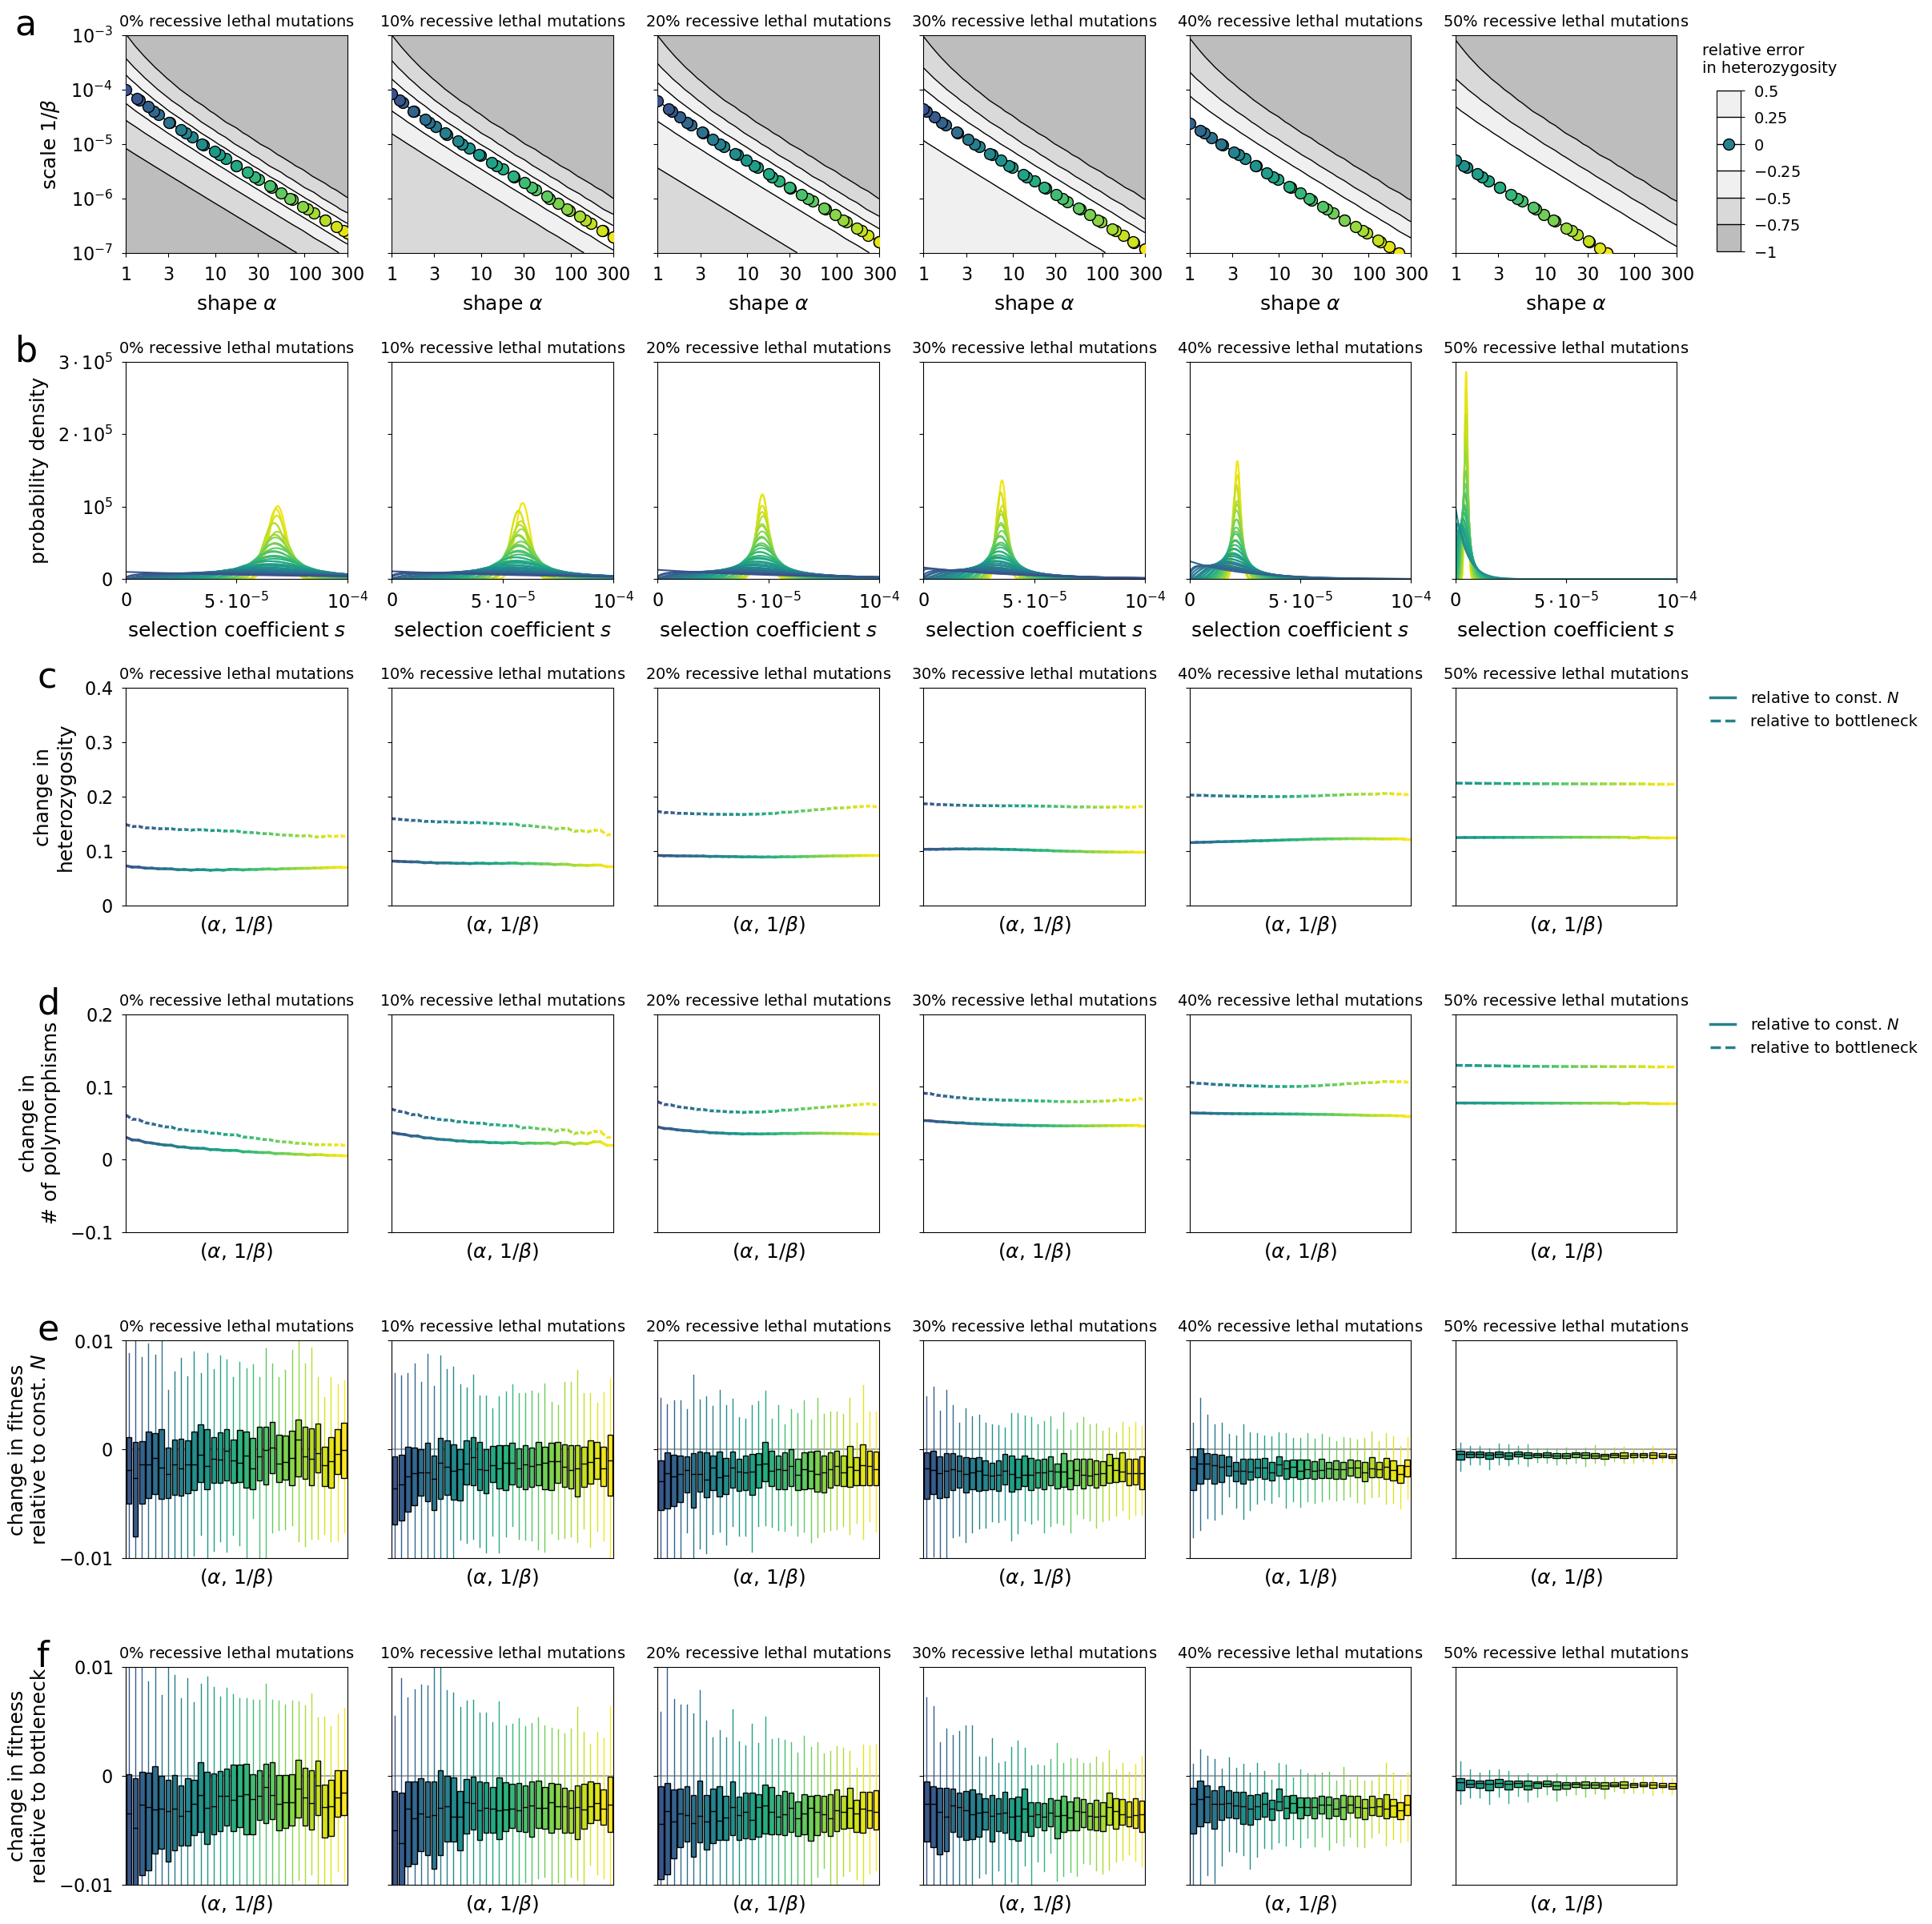

In [13]:
# making one large plot w/ all panels – this takes a while!

matplotlib.rcParams['xtick.major.pad']='8'
matplotlib.rcParams['ytick.major.pad']='8'

colors = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=45),cmap=sns.color_palette("viridis_r", as_cmap=True))

fig = plt.figure(figsize=(25, 30))

grid = gridspec.GridSpec(ncols=6, nrows=6,
                         width_ratios=[1, 1, 1, 1, 1, 1], wspace=0.2,
                         height_ratios=[1, 1, 1, 1, 1, 1], hspace=0.5)
params_that_fit = {}

change_in_H = {}
change_in_n_pol = {}
change_in_H_decline_only = {}
change_in_n_pol_decline_only = {}

for f in range(len(fracs) * 6):
    
    plt.subplot(grid[f // len(fracs), f % len(fracs)])
    
    # first panel
    if f // len(fracs) == 0:
        
        # creating meshgrids
        x = np.empty(shape=(n, n))
        y = np.empty(shape=(n, n))
        error = np.empty(shape=(n, n))
        for i in range(n):
            for j in range(n):
                x[i][j] = alphas[j]
                y[i][j] = scales[i]
                error[i][j] = (H_out[fracs[f]][alphas[j], scales[i]] - H) / H
            
        contours = plt.contourf(x, y, error, levels=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], 
                                colors=('#bdbdbd', '#d9d9d9', '#f0f0f0', '#ffffff', '#ffffff', '#f0f0f0', '#d9d9d9', '#bdbdbd'), extend='neither')
    
        plt.contour(x, y, error, levels=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], colors='black', linestyles='solid', linewidths=1)
       
        # extracting parameters that explain heterozygosity
        contour_lines = plt.contour(x, y, error, levels=[0], colors='black', alpha=0)
        params_that_fit[fracs[f]] = sorted(contour_lines.collections[0].get_paths()[0].to_polygons()[0], key = lambda x: x[-1])
    
        for i, (x, y) in enumerate(params_that_fit[fracs[f]]):
            plt.scatter(x, y, s=100, color=colors.to_rgba(i), edgecolors='#000000', zorder=10)
            #print(get_H(x, y, s, [x[1] for x in avg_H_codominant_s_const_N_lowess], H_recessive_lethal_const_N, fracs[f]))
            
        # for color bar
        if f == 5:
            plt.text(300 * 1.9, 1e-4 * 2, 'relative error\nin heterozygosity', size=14)
           
        plt.xscale('log');
        plt.yscale('log');
        plt.minorticks_off();
    
        plt.xlim(1, 300)
        plt.ylim(1e-7, 1e-3)
        plt.xticks([1, 3, 10, 30, 100, 300], ['$1$', '$3$', '$10$', '$30$', '$100$', '$300$'], size=16)
    
        if f == 0:
            plt.yticks([1e-7, 1e-6, 1e-5, 1e-4, 1e-3], ['$10^{-7}$', '$10^{-6}$', '$10^{-5}$', '$10^{-4}$', '$10^{-3}$'], size=16)
        else: 
            plt.yticks([1e-7, 1e-6, 1e-5, 1e-4, 1e-3], [])
        
        plt.xlabel('shape $α$', labelpad=8, fontsize=18);
    
        if f == 0:
            ax = plt.gca()
            plt.text(-0.5, 1, 'a', fontsize=32, transform=ax.transAxes)
            plt.ylabel('scale $1/β$', labelpad=8, fontsize=18);
        
        plt.title(f"${fracs[f]*100:.0f}\%$" + ' recessive lethal mutations', fontsize=14, pad=8)

        
    # second panel
    elif f // len(fracs) == 1:
        
        for i, (alpha, scale) in enumerate(params_that_fit[fracs[f%len(fracs)]]):
        
            x = np.linspace(0.0001, 0, int(1e4))
            c = colors.to_rgba(i)
        
            norm = gamma.cdf(1, alpha, scale=scale) # rescaling such that it integrates to 1
            plt.plot(x, (1 - fracs[f%len(fracs)]) * gamma.pdf(x, alpha, scale=scale) / norm, color=c)
            
        if f % len(fracs) == 0:
            plt.yticks([0, 100000, 200000, 300000], ['$0$', '$10^{5}$', r'$2\cdot10^{5}$', r'$3\cdot10^{5}$'], size=16)
        else:
            plt.yticks([0, 100000, 200000, 300000], [])
        
        plt.xticks([0, 0.00005, 0.0001], ['$0$', '$5\cdot10^{-5}$', '$10^{-4}$'], size=16)
    
        plt.ylim(0, 300000)
        plt.xlim(0, 0.0001)
        
        plt.xlabel('selection coefficient $s$', labelpad=8, fontsize=18);
        if f % len(fracs)  == 0:
            ax = plt.gca()
            plt.text(-0.5, 1, 'b', fontsize=32, transform=ax.transAxes)
            plt.ylabel('probability density', labelpad=8, fontsize=18);
        
        plt.title(f"${fracs[f%len(fracs)]*100:.0f}\%$" + ' recessive lethal mutations', fontsize=14, pad=8)

    # third panel:
    elif f // len(fracs) == 2:
        
        frac = fracs[f % len(fracs)]
        
        change_in_H[frac] = []
        change_in_H_decline_only[frac] = []
        
        change_in_n_pol[frac] = []
        change_in_n_pol_decline_only[frac] = []
   
        for i, (alpha, scale) in enumerate(params_that_fit[frac]):
            
            het = get_H(alpha, scale, s, [x[1] for x in avg_H_codominant_s_lowess], H_recessive_lethal, frac)[0]
            het_const_N = get_H(alpha, scale, s, [x[1] for x in avg_H_codominant_s_const_N_lowess], H_recessive_lethal_const_N, frac)[0]
            het_decline_only = get_H(alpha, scale, s, [x[1] for x in avg_H_codominant_s_decline_only_lowess], H_recessive_lethal_decline_only, frac)[0]
        
            change_in_H[frac].append([i, (alpha, scale), (het - het_const_N) / het_const_N])
            change_in_H_decline_only[frac].append([i, (alpha, scale), (het - het_decline_only) / het_decline_only])
            
        for i in range(len(change_in_H[frac]) - 1):
            plt.plot([-x[0] for x in change_in_H[frac]][i:i+2], [y[-1] for y in change_in_H[frac]][i:i+2], color=colors.to_rgba(change_in_H[frac][i][0]), linewidth=2.5)
            
        for i in range(len(change_in_H_decline_only[frac]) - 1):
            plt.plot([-x[0] for x in change_in_H_decline_only[frac]][i:i+2], [y[-1] for y in change_in_H_decline_only[frac]][i:i+2], color=colors.to_rgba(change_in_H[frac][i][0]), linewidth=2.5)
            plt.plot([-x[0] for x in change_in_H_decline_only[frac]][i:i+2], [y[-1] for y in change_in_H_decline_only[frac]][i:i+2], linestyle=(0, (0.7, 5)), color='#ffffff', linewidth=3)  
            
        # for legend
        if f % len(fracs) == 5:
            plt.plot([2, 3], [2, 3], linewidth=2.5, linestyle='-', color=colors.to_rgba(25), label='relative to const. $N$')
            plt.plot([2, 3], [2, 3], linewidth=2.5, linestyle='--', color=colors.to_rgba(25), label='relative to bottleneck')
            plt.legend(frameon=False, fontsize=14, loc='upper right', bbox_to_anchor=(2.15, 1.05), handletextpad=1, handlelength=1.6)

 
        if f % len(fracs) == 0:
            ax = plt.gca()
            plt.text(-0.4, 1, 'c', fontsize=32, transform=ax.transAxes)
            plt.yticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4], ['$-0.2$', '$-0.1$', '$0$', '$0.1$', '$0.2$', '$0.3$', '$0.4$'], size=16)
        else:
            plt.yticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4], [])
        
        plt.xticks([], [])
    
        plt.ylim(0, 0.4)
        plt.xlim(-len(params_that_fit[frac]) + 1, 0)
        
        plt.xlabel('($α$, $1/β$)', labelpad=8, fontsize=18);
        if f % len(fracs)  == 0:
            plt.ylabel('change in\nheterozygosity', labelpad=8, fontsize=18);
        
        plt.title(f"${fracs[f%len(fracs)]*100:.0f}\%$" + ' recessive lethal mutations', fontsize=14, pad=8)
        
    # fourth panel:
    elif f // len(fracs) == 3:
        
        frac = fracs[f % len(fracs)]
        
        change_in_n_pol[frac] = []
        change_in_n_pol_decline_only[frac] = []
   
        for i, (alpha, scale) in enumerate(params_that_fit[frac]):
                        
            n_pol = get_H(alpha, scale, s, [x[1] for x in avg_n_pol_codominant_s_lowess], n_pol_recessive_lethal, frac)[0]
            n_pol_const_N = get_H(alpha, scale, s, [x[1] for x in avg_n_pol_codominant_s_const_N_lowess], n_pol_recessive_lethal_const_N, frac)[0]
            n_pol_decline_only = get_H(alpha, scale, s, [x[1] for x in avg_n_pol_codominant_s_decline_only_lowess], n_pol_recessive_lethal_decline_only, frac)[0]
        
            change_in_n_pol[frac].append([i, (alpha, scale), (n_pol - n_pol_const_N) / n_pol_const_N])
            change_in_n_pol_decline_only[frac].append([i, (alpha, scale), (n_pol - n_pol_decline_only) / n_pol_decline_only])
            
        for i in range(len(change_in_n_pol[frac]) - 1):
            plt.plot([-x[0] for x in change_in_n_pol[frac]][i:i+2], [y[-1] for y in change_in_n_pol[frac]][i:i+2], color=colors.to_rgba(change_in_n_pol_decline_only[frac][i][0]), linewidth=2.5)
                        
        for i in range(len(change_in_n_pol_decline_only[frac]) - 1):
            plt.plot([-x[0] for x in change_in_n_pol_decline_only[frac]][i:i+2], [y[-1] for y in change_in_n_pol_decline_only[frac]][i:i+2], color=colors.to_rgba(change_in_n_pol_decline_only[frac][i][0]), linewidth=2.5)
            plt.plot([-x[0] for x in change_in_n_pol_decline_only[frac]][i:i+2], [y[-1] for y in change_in_n_pol_decline_only[frac]][i:i+2], linestyle=(0, (0.7, 5)), color='#ffffff', linewidth=3)  
                    
        # for legend
        if f % len(fracs) == 5:
            plt.plot([2, 3], [2, 3], linewidth=2.5, linestyle='-', color=colors.to_rgba(25), label='relative to const. $N$')
            plt.plot([2, 3], [2, 3], linewidth=2.5, linestyle='--', color=colors.to_rgba(25), label='relative to bottleneck')
            plt.legend(frameon=False, fontsize=14, loc='upper right', bbox_to_anchor=(2.15, 1.05), handletextpad=1, handlelength=1.6)

 
        if f % len(fracs) == 0:
            ax = plt.gca()
            plt.text(-0.4, 1, 'd', fontsize=32, transform=ax.transAxes)
            plt.yticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3], ['$-0.2$', '$-0.1$', '$0$', '$0.1$', '$0.2$', '$0.3$'], size=16)
        else:
            plt.yticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3], [])
        
        plt.xticks([], [])
    
        plt.ylim(-0.1, 0.2)
        plt.xlim(-len(params_that_fit[frac]) + 1, 0)
        
        plt.xlabel('($α$, $1/β$)', labelpad=8, fontsize=18);
        if f % len(fracs)  == 0:
            plt.ylabel('change in\n# of polymorphisms', labelpad=8, fontsize=18);
        
        plt.title(f"${fracs[f%len(fracs)]*100:.0f}\%$" + ' recessive lethal mutations', fontsize=14, pad=8)        
        
    # fifth panel:
    elif f // len(fracs) == 4:
        
        plt.axhline(0, color='#a9a9a9', zorder=-2)
        
        cs = []
        pts = []
        # utilizing the fact that params_that_fit are are in order of beta
        for i, k in enumerate(sorted(avg_fitness_diff[fracs[f%len(fracs)]].keys(), key=lambda x: x[-1])):
            pts.append(avg_fitness_diff[fracs[f%len(fracs)]][k])
            cs.append(colors.to_rgba(i))
        boxplot = plt.boxplot(pts, positions=[-x for x in range(len(pts))], patch_artist=True, widths=0.8, showfliers=False, showcaps=False, medianprops={'color': '#000000', 'linewidth': 1})
        
        # filling w/ colors
        for patch, c in zip(boxplot['boxes'], cs):
            patch.set_facecolor(c)
    
        for whisker, c in zip(boxplot['whiskers'][::2], cs):
            whisker.set_color(c)
            whisker.set_zorder(-1)
            whisker.set_linewidth(1)
    
        for whisker, c in zip(boxplot['whiskers'][1::2], cs):
            whisker.set_color(c)
            whisker.set_zorder(-1)
            whisker.set_linewidth(1)
            
        if f % len(fracs) == 0:
            ax = plt.gca()
            plt.text(-0.4, 1, 'e', fontsize=32, transform=ax.transAxes)
            plt.yticks([-0.02, -0.01, 0, 0.01, 0.02], ['$-0.02$', '$-0.01$', '$0$', '$0.01$', '$0.02$'], size=16)
        else:
            plt.yticks([-0.02, -0.01, 0, 0.01, 0.02], [])
        
        plt.xticks([], [])
    
        plt.ylim(-0.01, 0.01)
        
        plt.xlabel('($α$, $1/β$)', labelpad=8, fontsize=18);
        if f % len(fracs)  == 0:
            plt.ylabel('change in fitness\nrelative to const. $N$', labelpad=8, fontsize=18);
        
        plt.title(f"${fracs[f%len(fracs)]*100:.0f}\%$" + ' recessive lethal mutations', fontsize=14, pad=8)
        
    # sixth panel:
    elif f // len(fracs) == 5:
        
        plt.axhline(0, color='#a9a9a9', zorder=-2)
        
        cs = []
        pts = []
        # utilizing the fact that params_that_fit are are in order of beta
        for i, k in enumerate(sorted(avg_fitness_diff_decline_only[fracs[f%len(fracs)]].keys(), key=lambda x: x[-1])):
            pts.append(avg_fitness_diff_decline_only[fracs[f%len(fracs)]][k])
            cs.append(colors.to_rgba(i))
        boxplot = plt.boxplot(pts, positions=[-x for x in range(len(pts))], patch_artist=True, widths=0.8, showfliers=False, showcaps=False, medianprops={'color': '#000000', 'linewidth': 1})
        
        # filling w/ colors
        for patch, c in zip(boxplot['boxes'], cs):
            patch.set_facecolor(c)
    
        for whisker, c in zip(boxplot['whiskers'][::2], cs):
            whisker.set_color(c)
            whisker.set_zorder(-1)
            whisker.set_linewidth(1)
    
        for whisker, c in zip(boxplot['whiskers'][1::2], cs):
            whisker.set_color(c)
            whisker.set_zorder(-1)
            whisker.set_linewidth(1)
            
        if f % len(fracs) == 0:
            ax = plt.gca()
            plt.text(-0.4, 1, 'f', fontsize=32, transform=ax.transAxes)
            plt.yticks([-0.02, -0.01, 0, 0.01, 0.02], ['$-0.02$', '$-0.01$', '$0$', '$0.01$', '$0.02$'], size=16)
        else:
            plt.yticks([-0.02, -0.01, 0, 0.01, 0.02], [])
        
        plt.xticks([], [])
    
        plt.ylim(-0.01, 0.01)
        
        plt.xlabel('($α$, $1/β$)', labelpad=8, fontsize=18);
        if f % len(fracs)  == 0:
            plt.ylabel('change in fitness\nrelative to bottleneck', labelpad=8, fontsize=18);
        
        plt.title(f"${fracs[f%len(fracs)]*100:.0f}\%$" + ' recessive lethal mutations', fontsize=14, pad=8)
        
# colorbar for panel (a) 
cbar_ax = fig.add_axes([0.92, 0.79, 0.012, 0.067])
cbar = plt.colorbar(contours, alpha=1, cax=cbar_ax, orientation='vertical', shrink=0.5, ticks=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
cbar.ax.set_yticklabels(['$-1$', '$-0.75$', '$-0.5$', '$-0.25$', '$0$', '$0.25$', '$0.5$', '$0.75$', '$1$'])
for y in [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]:
    cbar.ax.axhline(y, color='#000000', linewidth=1)
cbar.ax.scatter(0.5, 0, s=100, color=colors.to_rgba(25), edgecolors='#000000', zorder=10)
cbar.ax.set_ylim(-1, 0.5)
cbar.ax.tick_params(labelsize=14)

# saving the figure
plt.savefig('H.pdf', dpi=600, bbox_inches='tight')

out = []
for frac in fracs:
    for params in params_that_fit[frac]:
        out.append('frac. of recessive lethals = ' + str(frac) + '; alpha = ' + str(params[0]) + '; 1/beta = ' + str(params[1]) + '\n')

# saving the output, uncomment if needed
with open(out_path, 'w+') as o:
    o.writelines(out)


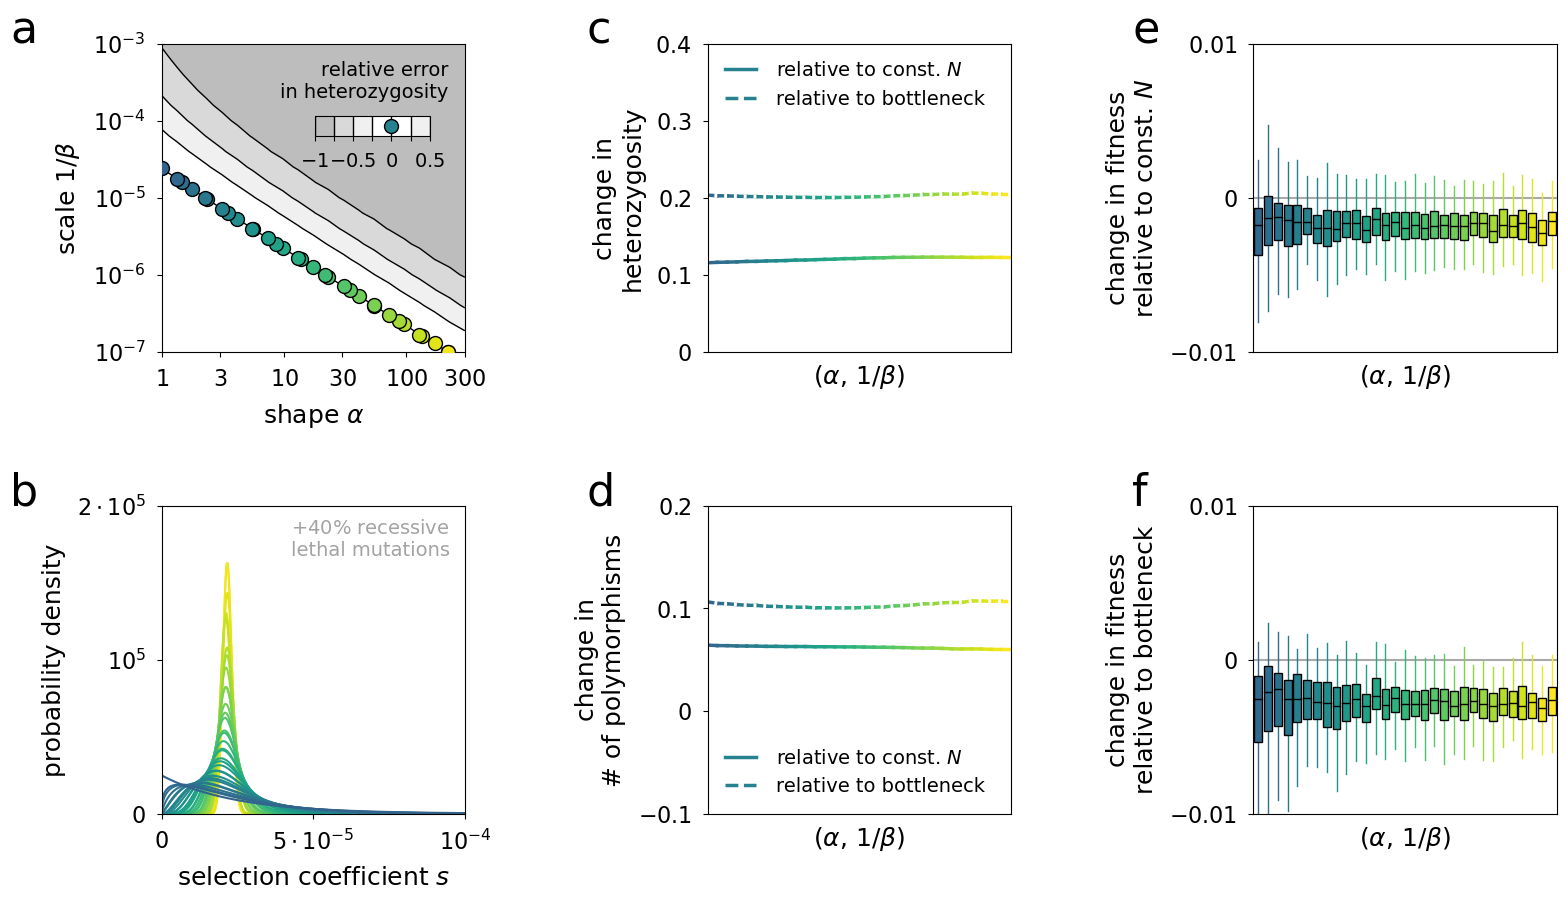

In [14]:
### making a smaller one

matplotlib.rcParams['xtick.major.pad']='8'
matplotlib.rcParams['ytick.major.pad']='8'

colors = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=45),cmap=sns.color_palette("viridis_r", as_cmap=True))

fig = plt.figure(figsize=(18, 10))

grid = gridspec.GridSpec(ncols=3, nrows=2,
                         width_ratios=[1, 1, 1], wspace=0.8,
                         height_ratios=[1, 1], hspace=0.5)
params_that_fit = {}

change_in_H = {}
change_in_n_pol = {}
change_in_H_decline_only = {}
change_in_n_pol_decline_only = {}

# choosing 0.4 lethals
f = 4
for c in range(6):
    plt.subplot(grid[c // 3, c % 3])
    
    # first panel
    if c == 0:
        
        # creating meshgrids
        x = np.empty(shape=(n, n))
        y = np.empty(shape=(n, n))
        error = np.empty(shape=(n, n))
        for i in range(n):
            for j in range(n):
                x[i][j] = alphas[j]
                y[i][j] = scales[i]
                error[i][j] = (H_out[fracs[f]][alphas[j], scales[i]] - H) / H
            
        contours = plt.contourf(x, y, error, levels=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], 
                                colors=('#bdbdbd', '#d9d9d9', '#f0f0f0', '#ffffff', '#ffffff', '#f0f0f0', '#d9d9d9', '#bdbdbd'), extend='neither')
    
        plt.contour(x, y, error, levels=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], colors='black', linestyles='solid', linewidths=1)
       
        # extracting parameters that explain heterozygosity
        contour_lines = plt.contour(x, y, error, levels=[0], colors='black', alpha=0)
        params_that_fit[fracs[f]] = sorted(contour_lines.collections[0].get_paths()[0].to_polygons()[0], key = lambda x: x[-1])
    
        for i, (x, y) in enumerate(params_that_fit[fracs[f]]):
            plt.scatter(x, y, s=100, color=colors.to_rgba(i), edgecolors='#000000', zorder=10)
            #print(get_H(x, y, s, [x[1] for x in avg_H_codominant_s_const_N_lowess], H_recessive_lethal_const_N, fracs[f]))
            
        plt.text(220, 1e-4 * 2, 'relative error\nin heterozygosity', ha='right', size=14)
           
        plt.xscale('log');
        plt.yscale('log');
        plt.minorticks_off();
    
        plt.xlim(1, 300)
        plt.ylim(1e-7, 1e-3)
        
        plt.xticks([1, 3, 10, 30, 100, 300], ['$1$', '$3$', '$10$', '$30$', '$100$', '$300$'], size=16)
        plt.yticks([1e-7, 1e-6, 1e-5, 1e-4, 1e-3], ['$10^{-7}$', '$10^{-6}$', '$10^{-5}$', '$10^{-4}$', '$10^{-3}$'], size=16)
        
        plt.xlabel('shape $α$', labelpad=8, fontsize=18);
        
        ax = plt.gca()
        plt.text(-0.5, 1, 'a', fontsize=32, transform=ax.transAxes)
        plt.ylabel('scale $1/β$', labelpad=8, fontsize=18);
             
        
    # second panel
    elif c == 3:
        
        for i, (alpha, scale) in enumerate(params_that_fit[fracs[f%len(fracs)]]):
        
            x = np.linspace(0.0001, 0, int(1e4))
            c = colors.to_rgba(i)
        
            norm = gamma.cdf(1, alpha, scale=scale) # rescaling such that it integrates to 1
            plt.plot(x, (1 - fracs[f%len(fracs)]) * gamma.pdf(x, alpha, scale=scale) / norm, color=c)
            
        plt.yticks([0, 100000, 200000], ['$0$', '$10^{5}$', r'$2\cdot10^{5}$'], size=16)
        plt.xticks([0, 0.00005, 0.0001], ['$0$', '$5\cdot10^{-5}$', '$10^{-4}$'], size=16)
    
        plt.ylim(0, 200000)
        plt.xlim(0, 0.0001)
        
        plt.xlabel('selection coefficient $s$', labelpad=8, fontsize=18);
 
        ax = plt.gca()
        plt.text(-0.5, 1, 'b', fontsize=32, transform=ax.transAxes)
        plt.ylabel('probability density', labelpad=8, fontsize=18);
        
        plt.text(0.95e-4, 1.675e5, f"$+{fracs[f]*100:.0f}\%$" + ' recessive\nlethal mutations', ha='right', color='#a3a3a3', size=14)
        
        
    # third panel:
    elif c == 1:
        
        frac = fracs[f]
        
        change_in_H[frac] = []
        change_in_H_decline_only[frac] = []
        
        change_in_n_pol[frac] = []
        change_in_n_pol_decline_only[frac] = []
   
        for i, (alpha, scale) in enumerate(params_that_fit[frac]):
            
            het = get_H(alpha, scale, s, [x[1] for x in avg_H_codominant_s_lowess], H_recessive_lethal, frac)[0]
            het_const_N = get_H(alpha, scale, s, [x[1] for x in avg_H_codominant_s_const_N_lowess], H_recessive_lethal_const_N, frac)[0]
            het_decline_only = get_H(alpha, scale, s, [x[1] for x in avg_H_codominant_s_decline_only_lowess], H_recessive_lethal_decline_only, frac)[0]
        
            change_in_H[frac].append([i, (alpha, scale), (het - het_const_N) / het_const_N])
            change_in_H_decline_only[frac].append([i, (alpha, scale), (het - het_decline_only) / het_decline_only])
            
        for i in range(len(change_in_H[frac]) - 1):
            plt.plot([-x[0] for x in change_in_H[frac]][i:i+2], [y[-1] for y in change_in_H[frac]][i:i+2], color=colors.to_rgba(change_in_H[frac][i][0]), linewidth=2.5)
            
        for i in range(len(change_in_H_decline_only[frac]) - 1):
            plt.plot([-x[0] for x in change_in_H_decline_only[frac]][i:i+2], [y[-1] for y in change_in_H_decline_only[frac]][i:i+2], color=colors.to_rgba(change_in_H[frac][i][0]), linewidth=2.5)
            plt.plot([-x[0] for x in change_in_H_decline_only[frac]][i:i+2], [y[-1] for y in change_in_H_decline_only[frac]][i:i+2], linestyle=(0, (0.7, 5)), color='#ffffff', linewidth=3)  
            
        # for legend
        plt.plot([2, 3], [2, 3], linewidth=2.5, linestyle='-', color=colors.to_rgba(25), label='relative to const. $N$')
        plt.plot([2, 3], [2, 3], linewidth=2.5, linestyle='--', color=colors.to_rgba(25), label='relative to bottleneck')
        plt.legend(frameon=False, fontsize=14, loc='upper left', handletextpad=1, handlelength=1.6)

        ax = plt.gca()
        plt.text(-0.4, 1, 'c', fontsize=32, transform=ax.transAxes)
        plt.yticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4], ['$-0.2$', '$-0.1$', '$0$', '$0.1$', '$0.2$', '$0.3$', '$0.4$'], size=16)
        
        plt.xticks([], [])
    
        plt.ylim(0, 0.4)
        plt.xlim(-len(params_that_fit[frac]) + 1, 0)
        
        plt.xlabel('($α$, $1/β$)', labelpad=8, fontsize=18);
        plt.ylabel('change in\nheterozygosity', labelpad=8, fontsize=18);
        
        
    # fourth panel:
    elif c == 4:
        
        frac = fracs[f]
        
        change_in_n_pol[frac] = []
        change_in_n_pol_decline_only[frac] = []
   
        for i, (alpha, scale) in enumerate(params_that_fit[frac]):
                        
            n_pol = get_H(alpha, scale, s, [x[1] for x in avg_n_pol_codominant_s_lowess], n_pol_recessive_lethal, frac)[0]
            n_pol_const_N = get_H(alpha, scale, s, [x[1] for x in avg_n_pol_codominant_s_const_N_lowess], n_pol_recessive_lethal_const_N, frac)[0]
            n_pol_decline_only = get_H(alpha, scale, s, [x[1] for x in avg_n_pol_codominant_s_decline_only_lowess], n_pol_recessive_lethal_decline_only, frac)[0]
        
            change_in_n_pol[frac].append([i, (alpha, scale), (n_pol - n_pol_const_N) / n_pol_const_N])
            change_in_n_pol_decline_only[frac].append([i, (alpha, scale), (n_pol - n_pol_decline_only) / n_pol_decline_only])
            
        for i in range(len(change_in_n_pol[frac]) - 1):
            plt.plot([-x[0] for x in change_in_n_pol[frac]][i:i+2], [y[-1] for y in change_in_n_pol[frac]][i:i+2], color=colors.to_rgba(change_in_n_pol_decline_only[frac][i][0]), linewidth=2.5)
                        
        for i in range(len(change_in_n_pol_decline_only[frac]) - 1):
            plt.plot([-x[0] for x in change_in_n_pol_decline_only[frac]][i:i+2], [y[-1] for y in change_in_n_pol_decline_only[frac]][i:i+2], color=colors.to_rgba(change_in_n_pol_decline_only[frac][i][0]), linewidth=2.5)
            plt.plot([-x[0] for x in change_in_n_pol_decline_only[frac]][i:i+2], [y[-1] for y in change_in_n_pol_decline_only[frac]][i:i+2], linestyle=(0, (0.7, 5)), color='#ffffff', linewidth=3)  
                    
        # for legend
        plt.plot([2, 3], [2, 3], linewidth=2.5, linestyle='-', color=colors.to_rgba(25), label='relative to const. $N$')
        plt.plot([2, 3], [2, 3], linewidth=2.5, linestyle='--', color=colors.to_rgba(25), label='relative to bottleneck')
        plt.legend(frameon=False, fontsize=14, loc='lower left', handletextpad=1, handlelength=1.6)
        
        ax = plt.gca()
        plt.text(-0.4, 1, 'd', fontsize=32, transform=ax.transAxes)
        plt.yticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3], ['$-0.2$', '$-0.1$', '$0$', '$0.1$', '$0.2$', '$0.3$'], size=16)
        
        plt.xticks([], [])
    
        plt.ylim(-0.1, 0.2)
        plt.xlim(-len(params_that_fit[frac]) + 1, 0)
        
        plt.xlabel('($α$, $1/β$)', labelpad=8, fontsize=18);
        plt.ylabel('change in\n# of polymorphisms', labelpad=8, fontsize=18);
        
        
    # fifth panel:
    elif c == 2:
        
        plt.axhline(0, color='#a9a9a9', zorder=-2)
        
        cs = []
        pts = []
        # utilizing the fact that params_that_fit are are in order of beta
        for i, k in enumerate(sorted(avg_fitness_diff[fracs[f%len(fracs)]].keys(), key=lambda x: x[-1])):
            pts.append(avg_fitness_diff[fracs[f%len(fracs)]][k])
            cs.append(colors.to_rgba(i))
        boxplot = plt.boxplot(pts, positions=[-x for x in range(len(pts))], patch_artist=True, widths=0.8, showfliers=False, showcaps=False, medianprops={'color': '#000000', 'linewidth': 1})
        
        # filling w/ colors
        for patch, c in zip(boxplot['boxes'], cs):
            patch.set_facecolor(c)
    
        for whisker, c in zip(boxplot['whiskers'][::2], cs):
            whisker.set_color(c)
            whisker.set_zorder(-1)
            whisker.set_linewidth(1)
    
        for whisker, c in zip(boxplot['whiskers'][1::2], cs):
            whisker.set_color(c)
            whisker.set_zorder(-1)
            whisker.set_linewidth(1)
            
        ax = plt.gca()
        plt.text(-0.4, 1, 'e', fontsize=32, transform=ax.transAxes)
        plt.yticks([-0.02, -0.01, 0, 0.01, 0.02], ['$-0.02$', '$-0.01$', '$0$', '$0.01$', '$0.02$'], size=16)
        
        plt.xticks([], [])
        plt.ylim(-0.01, 0.01)
        
        plt.xlabel('($α$, $1/β$)', labelpad=8, fontsize=18);
        plt.ylabel('change in fitness\nrelative to const. $N$', labelpad=8, fontsize=18);
        
        
    # sixth panel:
    elif c == 5:
        
        plt.axhline(0, color='#a9a9a9', zorder=-2)
        
        cs = []
        pts = []
        # utilizing the fact that params_that_fit are are in order of beta
        for i, k in enumerate(sorted(avg_fitness_diff_decline_only[fracs[f%len(fracs)]].keys(), key=lambda x: x[-1])):
            pts.append(avg_fitness_diff_decline_only[fracs[f%len(fracs)]][k])
            cs.append(colors.to_rgba(i))
        boxplot = plt.boxplot(pts, positions=[-x for x in range(len(pts))], patch_artist=True, widths=0.8, showfliers=False, showcaps=False, medianprops={'color': '#000000', 'linewidth': 1})
        
        # filling w/ colors
        for patch, c in zip(boxplot['boxes'], cs):
            patch.set_facecolor(c)
    
        for whisker, c in zip(boxplot['whiskers'][::2], cs):
            whisker.set_color(c)
            whisker.set_zorder(-1)
            whisker.set_linewidth(1)
    
        for whisker, c in zip(boxplot['whiskers'][1::2], cs):
            whisker.set_color(c)
            whisker.set_zorder(-1)
            whisker.set_linewidth(1)
            
        ax = plt.gca()
        plt.text(-0.4, 1, 'f', fontsize=32, transform=ax.transAxes)
        plt.yticks([-0.02, -0.01, 0, 0.01, 0.02], ['$-0.02$', '$-0.01$', '$0$', '$0.01$', '$0.02$'], size=16)
        
        plt.xticks([], [])
        plt.ylim(-0.01, 0.01)
        
        plt.xlabel('($α$, $1/β$)', labelpad=8, fontsize=18);
        plt.ylabel('change in fitness\nrelative to bottleneck', labelpad=8, fontsize=18);
        
# colorbar for panel (a) 
cbar_ax = fig.add_axes([0.21, 0.788, 0.064, 0.02])  
cbar = plt.colorbar(contours, alpha=1, cax=cbar_ax, orientation='horizontal', ticks=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
cbar.ax.set_xticklabels(['$-1$', ' ', '$-0.5$', ' ', '$0$', ' ', '$0.5$', ' ', '$1$'])
for y in [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]:
    cbar.ax.axvline(y, color='#000000', linewidth=1)
cbar.ax.scatter(0, 0.5, s=100, color=colors.to_rgba(25), edgecolors='#000000', zorder=10)
cbar.ax.set_xlim(-1, 0.5)
cbar.ax.tick_params(labelsize=14)

# saving the figure
plt.savefig('H_p=0.4.pdf', dpi=600, bbox_inches='tight')